In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [2]:
%matplotlib notebook

# Test blobs

In [260]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


# Set responsivity params

In [6]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5


# Get all blob data

In [134]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']

optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type

print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [135]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

In [136]:
dsets = sdata[sdata['experiment']=='blobs']

In [140]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


# Create output dir for aggregated data

In [142]:
outdir = os.path.join(aggregate_dir, 'blob-tuning', stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-tuning/stats-traces001-corrected-dff-nstds-thr-10.00


In [143]:
dsets.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
6,JC084,blobs,FOV1_zoom2p0x,20190525,Lm,0,4
10,JC091,blobs,FOV1_zoom2p0x,20190627,Lm,0,7
14,JC091,blobs,FOV1_zoom2p0x,20190607,Li,0,7
18,JC091,blobs,FOV1_zoom2p0x,20190614,Li,0,7


# Create output dir for all session data

In [299]:
if not os.path.exists(os.path.join(outdir, 'sessions')):
    os.makedirs(os.path.join(outdir, 'sessions'))

# Out of the responsive cells, which are responsive to which condition?

In [292]:
from matplotlib.ticker import FormatStrFormatter


In [221]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [366]:
reload(util)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julian

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py'>

## 1. Look at "tuning curves"

In [367]:
# Set plotting params
threshold_dff = True
min_dff = 0.03
cmap = 'inferno'
n_sz = 5
n_mp = 10

tune_name='morph'

incorrect_nvalues = []


In [369]:
del exp

In [370]:
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    # Get stimulus conditions
    sdf = exp.get_stimuli()
    sdf = reformat_morph_values(sdf)
    sizes = sorted(sdf['size'].unique())
    morphs = sorted(sdf['morphlevel'].unique())

    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != n_sz or n_morphs != n_mp:
        incorrect_nvalues.append(skey)
        continue

    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']
    
    # Get metrics for each condition
    estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
    meanr = pd.concat([pd.Series(np.nanmean(estats.gdf.get_group(roi).groupby(['config']), axis=0)['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T

    # Get ROI list
    if threshold_dff:
        rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
    else:
        rois_plot = meanr.index.tolist()
    print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

    df = meanr.loc[rois_plot]

    hue_name = 'size' if tune_name=='morph' else 'morph'
    tune_values = morphs.copy() if tune_name=='morph' else sizes.copy()
    hue_values = sizes.copy() if tune_name=='morph' else morphs.copy()
    hcolors = sns.color_palette('gray_r', n_colors=n_sz) if tune_name=='morph' else sns.color_palette('gray_r', n_colors=n_mp) 

    fig = plot_roi_tuning(df, tune_values=tune_values, tune_name=tune_name,
                         hue_values=hue_values, hue_name=hue_name, hue_colors=hcolors)
    if threshold_dff:
        figname = '%s-tuning_%s__%s_thr-dff-%.2f_%irois' % (tune_name, visual_area, data_id.replace('|', '_'), min_dff, len(rois_plot))
    else:
        figname = '%s-tuning_%s__%s_all-resp_%irois' % (tune_namevisual_area, data_id.replace('|', '_'), len(rois_plot))
    pl.savefig(os.path.join(outdir, 'sessions', '%s.png' % figname))
    print figname
    pl.close()
    
    del exp


... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
ERROR LOADING DATA
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 999, in load
    F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/lib/npyio.py", line 233, in __getitem__
    pickle_kwargs=self.pickle_kwargs)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/lib/format.py", line 664, in read_array
    array = numpy.ndarray(count, dtype=dtype)
MemoryError


AttributeError: 'NoneType' object has no attribute 'traces'

#### Plot tuning curve for each ROI

<IPython.core.display.Javascript object>


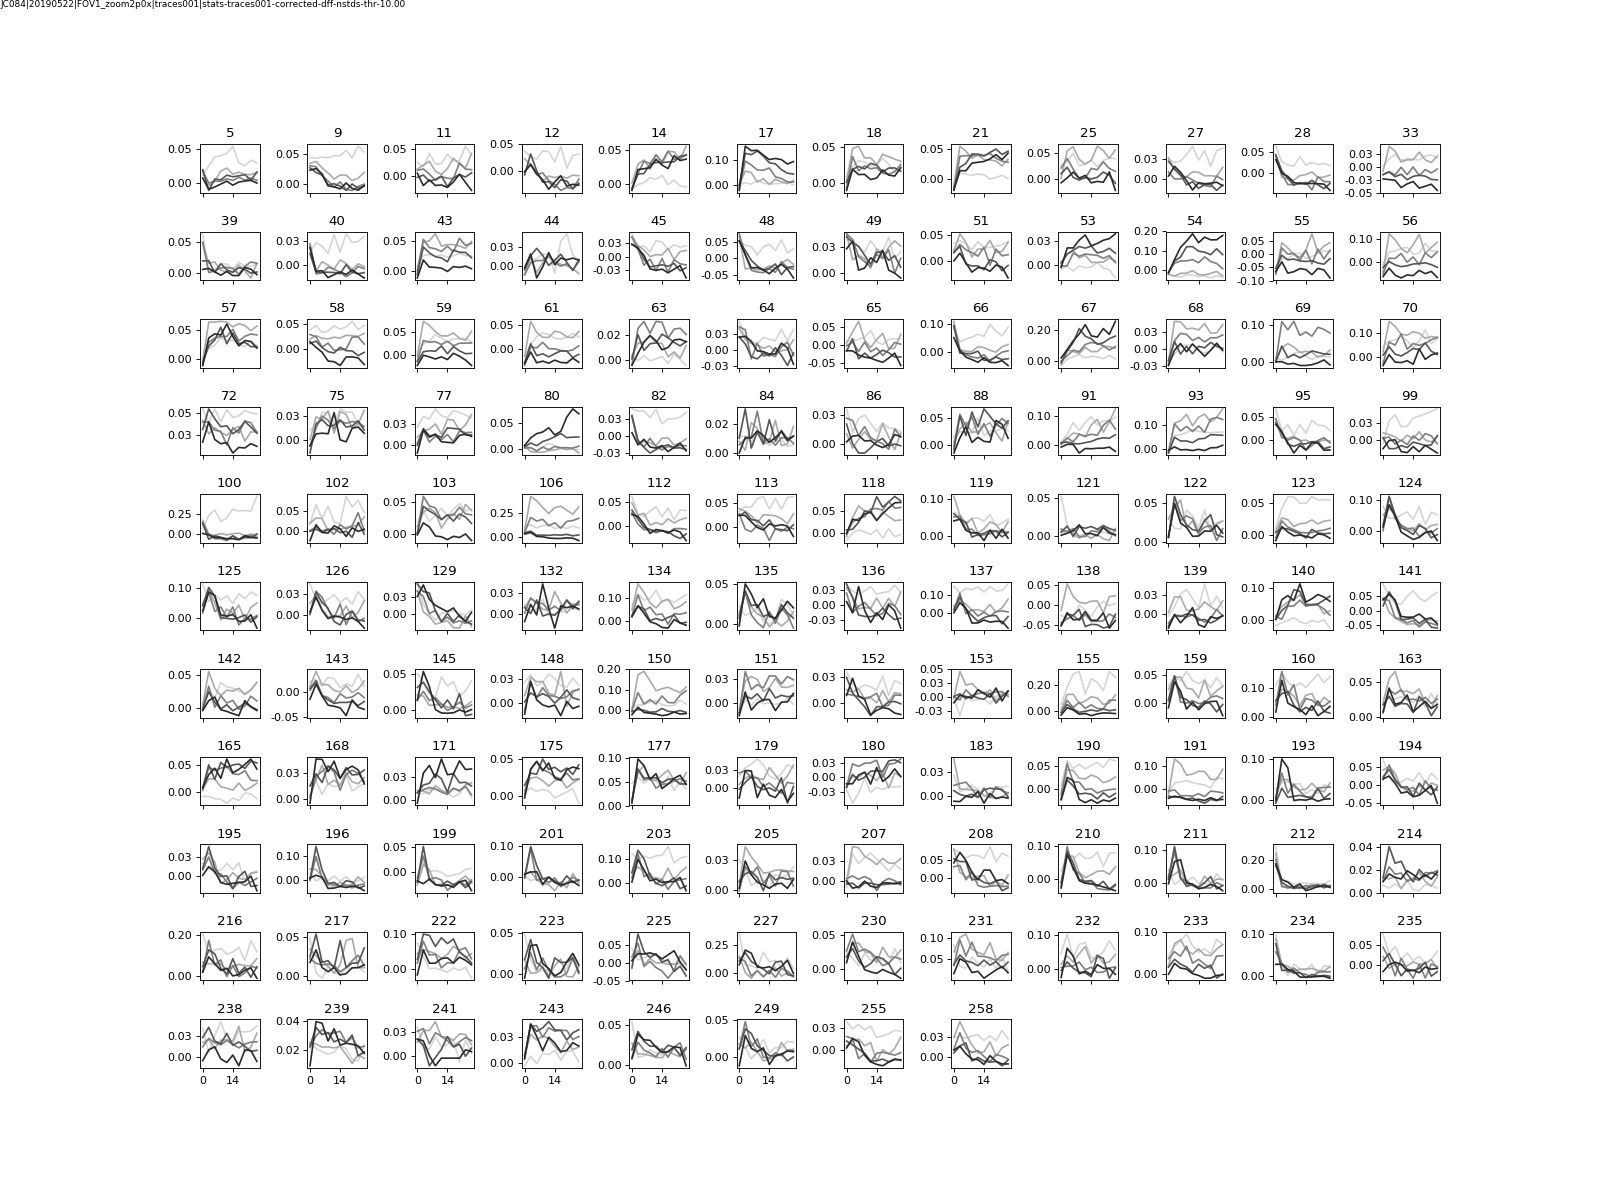

V1__JC084_20190522_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_128rois


In [359]:
def plot_roi_tuning(df, tune_values=None, tune_name='', hue_values=None, hue_name='', hue_colors=None):

    rois_plot = df.index.tolist()
    nrois_plot = len(rois_plot)
    print("N rois to plot: %i" % nrois_plot)
    nrows = int(round(np.sqrt(nrois_plot)))
    ncols = int(np.ceil(nrois_plot/float(nrows)))

    print(nrows, ncols)
    nsubplots = nrows*ncols

    vmin = df.min().min()
    vmax = df.max().max()

    fig, axes = pl.subplots(nrows, ncols, sharex=True, sharey=False, figsize=(20,15))
    fig.patch.set_alpha(1)
    for hv, hcolor in zip(hue_values, hue_colors):
        currcfgs = sdf[sdf[hue_name]==hv].index.tolist() #cols = [c for c in meanr.columns if 'S%i' % sz in c]
        for ax, roi in zip(axes.flat, rois_plot):
            ax.plot(np.arange(0, len(tune_values)), df[currcfgs].loc[roi].values, color=hcolor) #[roi])
            ax.set_xticklabels(tune_values)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.set_title(roi)

    label_figure(fig, data_id)
    for ax in axes.flat[nrois_plot:]:
        ax.axis('off')
    pl.subplots_adjust(wspace=0.8, hspace=0.8)

    return fig

# Look at counts across visual areas

In [154]:
incorrect_nconfigs = []
incorrect_nvalues = []
nresponsive = {}
ntotal = {}

In [155]:
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    skey = '%s-%s-%s' % (animalid, session, fov)

    sdf = exp.get_stimuli()
    if len(sdf.index.tolist()) != 50:
        incorrect_nconfigs.append(skey)
        continue

    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]
    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != nr or n_morphs != nc:
        incorrect_nvalues.append(skey)
        continue

    if visual_area not in nresponsive.keys():
        nresponsive[visual_area] = {}
        ntotal[visual_area] = {}
    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']


    ncells_arr = np.empty((nr, nc), dtype=int)
    for ri, sz in enumerate(sizes):
        for mi, mp in enumerate(morphs):
            assert sz in sdf['size'].unique(), "wrong size: %i" % sz
            assert mp in sdf['morphlevel'].unique(), "wrong morph: %i" % mp
            ax = axes[ri, mi]
            cfg = sdf[( (sdf['size']==sz) & (sdf['morphlevel']==mp) )].index[0]
            ncells_resp = len(np.where(rstats.loc[cfg] >= responsive_thr)[0])
            ncells_arr[ri, mi] = ncells_resp

    nresponsive[visual_area].update({skey: ncells_arr})
    ntotal[visual_area].update({skey: len(rlist)})
    
    
        

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data pa

In [157]:
print incorrect_nvalues
print incorrect_nconfigs

[]
['JC078-20190426-FOV1_zoom2p0x']


In [192]:
data_identifier = '|'.join(['blobs', fov_type, traceid, stats_desc])
print(data_identifier)

blobs|zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00


<IPython.core.display.Javascript object>


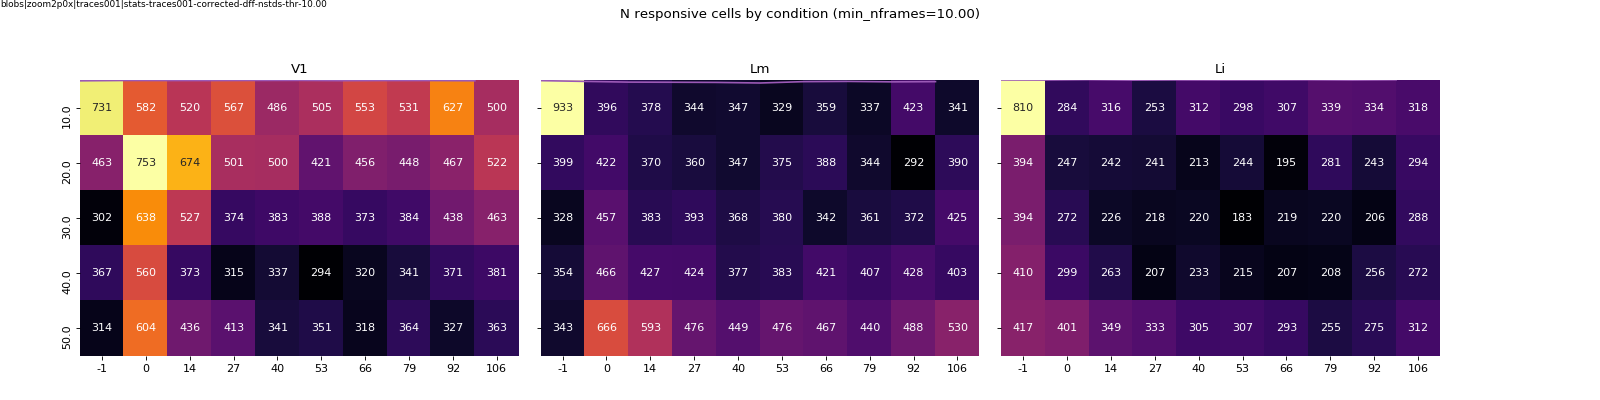

In [210]:
nr=5
nc=10
cmap = 'inferno'
normalize = False

fig, axes = pl.subplots(1,3, sharex=True, sharey=True, figsize=(20, 5))
fig.patch.set_alpha(1)
#vmin = 0
#vmax = 1
for ax, visual_area in zip(axes, ['V1', 'Lm', 'Li']):
    agg_arr = np.empty((nr, nc))
    sessionkeys = sorted(ntotal[visual_area].keys(), key=natural_keys)
    ncells_total = [ntotal[visual_area][k] for k in sessionkeys]
    resp_array = [nresponsive[visual_area][k] for k in sessionkeys]
    for ncells, r_arr in zip(ncells_total, resp_array):
        if normalize:
            agg_arr += (r_arr / float(ncells))
        else:
            agg_arr += r_arr
    
    if normalize:
        agg_arr = agg_arr / float(len(sessionkeys))
        sns.heatmap(agg_arr, ax=ax,cmap=cmap, #square=True, 
                    fmt='.2g', annot=True, cbar=0,
                    vmin=vmin, vmax=vmax)
    else:
        agg_arr = agg_arr.astype(int)
        sns.heatmap(agg_arr, ax=ax,cmap=cmap, #square=True, 
                    fmt='d', annot=True, cbar=0)
        
    ax.set_yticklabels(sizes)
    ax.set_xticklabels(morphs)    
    ax.set_title(visual_area)

if normalize:
    title = 'perc. of responsive cells by condition (min_nframes=%.2f)' % responsive_thr
    figname = 'ncells_responsive_by_condition-%s-thr-%.2f_normalized' % (responsive_test, responsive_thr)

else:
    title = 'N responsive cells by condition (min_nframes=%.2f)' % responsive_thr
    figname = 'ncells_responsive_by_condition-%s-thr-%.2f' % (responsive_test, responsive_thr)

fig.suptitle(title)

pl.subplots_adjust(wspace=0.05, left=0.05, top=0.8)
label_figure(fig, data_identifier)


pl.savefig(os.path.join(outdir, '%s.png' % figname ))


In [190]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-tuning/stats-traces001-corrected-dff-nstds-thr-10.00'

#### Look at num responsive for 1 session

In [ ]:
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'


In [101]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)

rstats, _, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

... loading ROI stats: nstds


In [226]:
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = sorted(sdf['size'].unique())
morphs = sorted(sdf['morphlevel'].unique())

Getting stimulus info for: combined_blobs_static


In [228]:

nr = len(sizes)
nc = len(morphs)

ncells_arr = np.empty((nr, nc), dtype=int)
#fig, axes = pl.subplots(nr, nc, sharex=True, sharey=True)
#cbar_ax = fig.add_axes([.91, .3, .03, .4])
#i  = 0
for ri, sz in enumerate(sizes):
    for mi, mp in enumerate(morphs):
        cfg = sdf[( (sdf['size']==sz) & (sdf['morphlevel']==mp) )].index[0]
        ncells_resp = len(np.where(rstats.loc[cfg] >= responsive_thr)[0])
        ncells_arr[ri, mi] = ncells_resp
        

<IPython.core.display.Javascript object>


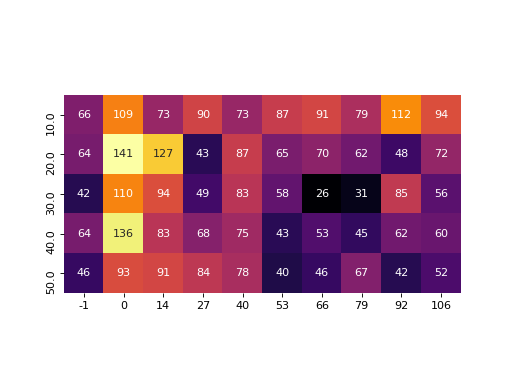

[Text(0.5,0,u'-1'),
 Text(1.5,0,u'0'),
 Text(2.5,0,u'14'),
 Text(3.5,0,u'27'),
 Text(4.5,0,u'40'),
 Text(5.5,0,u'53'),
 Text(6.5,0,u'66'),
 Text(7.5,0,u'79'),
 Text(8.5,0,u'92'),
 Text(9.5,0,u'106')]

In [229]:
fig, ax  = pl.subplots()
sns.heatmap(ncells_arr, ax=ax,cmap=cmap, square=True, fmt='d', annot=True, cbar=0)
ax.set_yticklabels(sizes)
ax.set_xticklabels(morphs)